[*********************100%***********************]  1 of 1 completed
RMSE: 0.022288456692193294
MAE: 0.01701361924033525
R2: 0.9412492626398956
MAPE (ARIMA): 0.02%
Theil U statistic (ARIMA): 0.24
Profit/Loss after 352 time steps (ARIMA): $72.86


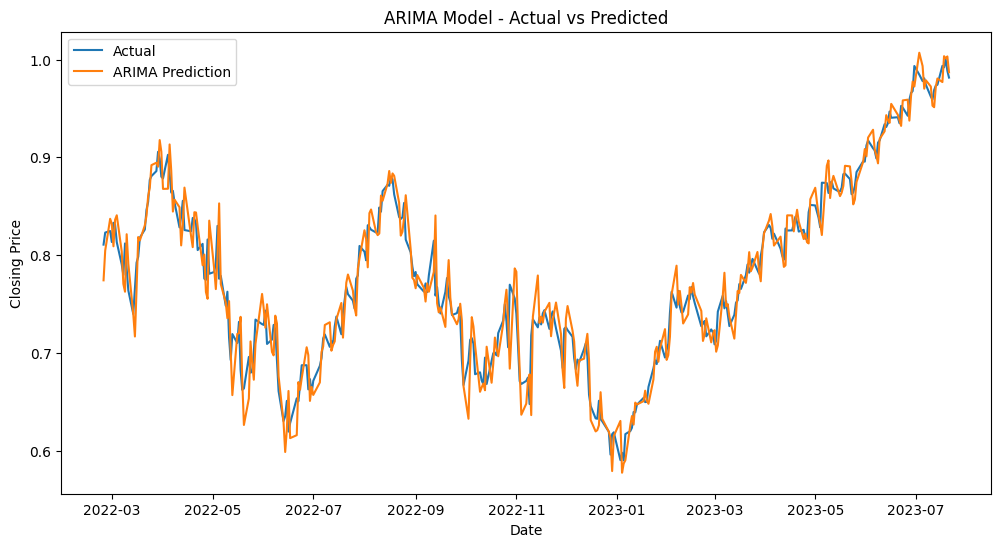

In [9]:
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import yfinance as yf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA

warnings.simplefilter("ignore")

tf.random.set_seed(455)
np.random.seed(455)

ticker = "AAPL"
end = datetime.now()
start = datetime(2016, end.month, end.day)
dataset = yf.download(ticker, start, end)
dataset

# Preprocess the data
data = dataset['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

history = [x for x in train_data]
arima_predictions = []
for t in range(len(test_data)):
    model = ARIMA(history, order=(1, 2, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)
    obs = test_data[t]
    history.append(obs)


# Function to calculate Theil U statistic
def theil_u_statistic(actual, predicted, naive):
    mse_actual = mean_squared_error(actual, naive)
    mse_predicted = mean_squared_error(actual, predicted)
    theil_u = np.sqrt(mse_predicted / mse_actual)
    return theil_u


# Calculate RMSE
arima_rmse = np.sqrt(mean_squared_error(test_data, arima_predictions))
arima_mae = mean_absolute_error(test_data, arima_predictions)
arima_r2 = r2_score(test_data, arima_predictions)
arima_mape = mean_absolute_percentage_error(test_data, arima_predictions)
arima_naive_predictions = np.full_like(test_data, train_data[-1])
arima_theil_u = theil_u_statistic(test_data, arima_predictions, arima_naive_predictions)

print(f"RMSE: {arima_rmse}")
print(f"MAE: {arima_mae}")
print(f"R2: {arima_r2}")
print(f"MAPE: {arima_mape:.2f}%")
print(f"Theil U statistic : {arima_theil_u:.2f}")


# ... (previous code)

# Decide whether to buy or sell the stock based on predicted price movements
def decide_action_arima(predictions):
    actions = []
    for i in range(len(predictions) - 1):
        if predictions[i + 1] > predictions[i]:
            actions.append('buy')
        else:
            actions.append('sell')
    return actions


# Apply the ARIMA strategy
arima_actions = decide_action_arima(arima_predictions)


# Function to calculate profit or loss for ARIMA
def calculate_profit_loss_arima(actions, test_data, data):
    capital = 10000  # Starting capital
    stock_units = 0
    stock_price = 0
    for i in range(len(actions)):
        if actions[i] == 'buy':
            stock_units = capital // data[train_size + i]
            stock_price = data[train_size + i]
            capital -= stock_units * stock_price
        elif actions[i] == 'sell':
            if stock_units > 0:
                capital += stock_units * data[train_size + i]
                stock_units = 0
    if stock_units > 0:
        capital += stock_units * data[train_size + len(actions) - 1]  # Sell remaining stocks at the last price
    return capital


# Calculate profit/loss for ARIMA model
arima_N_time_steps = len(arima_actions)
arima_profit_loss = calculate_profit_loss_arima(arima_actions, test_data, data)
arima_profit_loss = float(arima_profit_loss)
print(f"Profit/Loss after {arima_N_time_steps} time steps (ARIMA): ${arima_profit_loss:.2f}")

# Plot the actual and ARIMA predicted values
plt.figure(figsize=(12, 6))
plt.plot(dataset.index[train_size:], test_data, label='Actual')
plt.plot(dataset.index[train_size:], arima_predictions, label='ARIMA Prediction')
plt.title('ARIMA Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()